In [5]:
# -*- coding: utf-8 -*-
"""
Created on Tue Apr  5 16:25:22 2022

@author: kurt_
"""
# %%
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# %%

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from scipy.stats import norm, skew #for some statistics
from scipy import stats

from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from statsmodels.tsa.tsatools import detrend

import os
import platform
op_sys = platform.system()
if op_sys == 'Windows':
    path = 'C:\\Users\\kurt_\\Google Drive\\dell_github\\T-Matrix-Titan\\special\\data\\'

elif op_sys == 'Linux':
    path = '/home/cihat/Dropbox/code/special/data/'
os.chdir(path)

In [8]:
# Function for reshaping data after power transformation
def reshape_after_pt(df_pt, df): 
    df_pt = pd.DataFrame(df_pt, columns=
                             df.columns)
    df_pt.index = df.index
    return df_pt

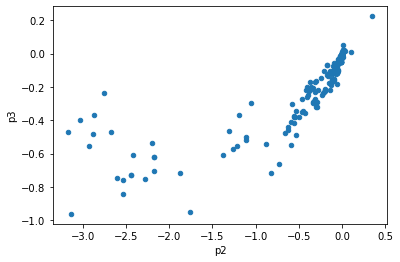

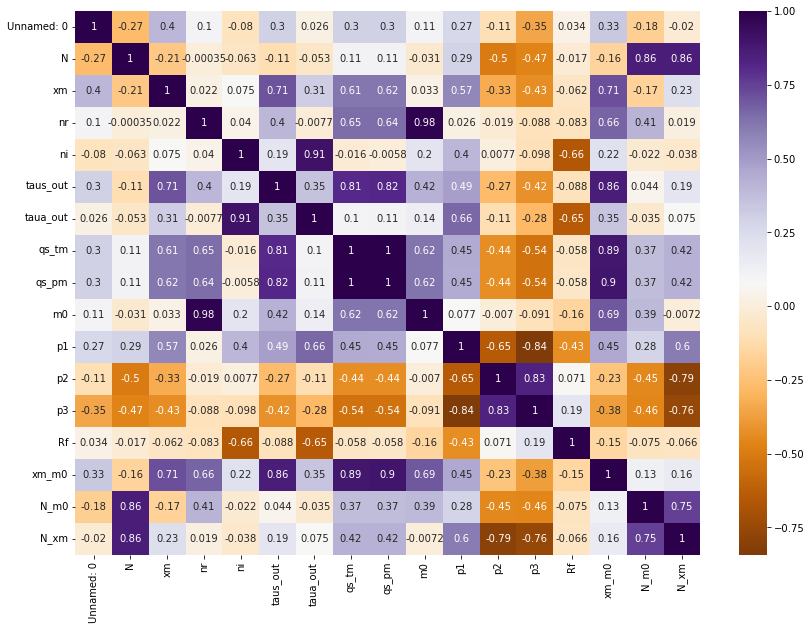

In [2]:
# Reading the coefficients data
df = pd.read_csv(path+'coefficients\\forward\\allregimes.csv')
# print(df.head())
df.plot(x='p2', y='p3', kind='scatter')
# Coefficients depend on each other as expected, not not strongly though.
# Above plotting shows that.
# If synthetic data will be created we should create p1,p2,p3 all together.
# let's plot pairwise correlation heatmap
f, ax = plt.subplots(figsize=(14, 10))
ax = sns.heatmap(df.corr(), annot=True, cmap='PuOr')
plt.show()

### Checking Normality of the Variables.
Regression models assume that the variables are normally distributed. Therefore the following steps will be applied to check for distribution of the variables and transform those with high skeweness and kurtosis distributions:

Do skewness test for each columns.

Consider those with absolute value of skewness > 0.5 as skewed the rest as acceptable

Apply box-cox transformation

In [3]:
# Skewness test
skewed = df.skew().sort_values(ascending=False)
pd.DataFrame({'skewness': skewed})

,skewness
ni,7.242152
taua_out,5.909194
taus_out,2.728589
p1,2.422946
N_m0,1.803837
N,1.365276
N_xm,1.181034
qs_tm,1.095866
qs_pm,1.086706
xm_m0,0.670716


Several variables are skewed. We can fix the skewness by applying power transformation to variables including the response variable.

In [11]:
# Apply yeo-johnson power transformation which is unlike box-cox method allows negative values
pt = PowerTransformer(method='yeo-johnson', standardize=True)
df_pt = pt.fit_transform(df)

df_pt = reshape_after_pt(df_pt, df)
pd.DataFrame(df_pt.skew().sort_values(ascending=False), columns=['skewness'])

,skewness
taus_out,0.542570
taua_out,0.522796
ni,0.462566
xm_m0,0.041719
qs_tm,0.040668
qs_pm,0.026611
N_m0,0.009827
xm,0.008445
p3,0.002861
N,-0.004033
